In [1]:
def detector_positions(alpha: float, phi: float, count: int, shape: tuple[int, int]) -> list[tuple[int, int]]:
    """
    Calculates locations of detectors in a fan-beam CT scanner.

    :param alpha: Emitter's angular position angle (in radians).
    :param phi: Detectors' angular span (in radians) [measured from circle's center].
    :param count: Number of detectors.
    :param radius: Radius of the circle (in pixels) [should be equal to image's diagonal length].
    :return: List of detector positions (x, y).    
    """

    from numpy import pi as PI, cos, sin, sqrt, round, int64

    w, h = shape
    radius = round(sqrt(w ** 2 + h ** 2) / 2).astype(int64)

    # We assume that detectors are laid evenly on arc drawn by `phi`.
    #
    # Because we want evenly-spaced detectors:
    #   step = arc length / segment no.
    # where arc length is de facto phi (as it is expressed in radians)
    # and segment no. is count - 1 (last detector is on edge so it doesn't count)
    angular_step = phi / (count - 1)

    # We assume center of detectors' fan is exactly vis-a-vis the emitter position.
    start_angle = alpha + PI - (phi / 2)

    x = lambda index: round(cos(start_angle + angular_step * index) * radius).astype(int64) + (w // 2)
    y = lambda index: round(sin(start_angle + angular_step * index) * radius).astype(int64) + (h // 2)

    return [(x(no), y(no)) for no in range(count)]


def emitter_position(alpha: float, shape: tuple[int, int]) -> list[tuple[int, int]]:
    """
    Calculates emitter's location in a fan-beam CT scanner.

    :param alpha: Emitter's angular position (in radians).
    :param radius: Radius of the circle (in pixels) [should be equal to image's diagonal length].
    :return: Emitter's position (x, y).
    """

    from numpy import cos, sin, sqrt, round, int64

    w, h = shape
    radius = round(sqrt(w ** 2 + h ** 2) / 2).astype(int64)

    x = round(cos(alpha) * radius).astype(int64) + (w // 2)
    y = round(sin(alpha) * radius).astype(int64) + (h // 2)

    return (x, y)

In [2]:
from numpy import pi

emitter = emitter_position(0.0, (8, 6))
print("Emitter (α = 0)", emitter)
emitter = emitter_position(pi / 4, (8, 6))
print("Emitter (α = π / 4)", emitter)
emitter = emitter_position(pi / 2, (8, 6))
print("Emitter (α = π / 2)", emitter)
emitter = emitter_position(pi, (8, 6))
print("Emitter (α = π)", emitter)

detectors = detector_positions(0.0, pi, 5, (8, 6))
print("Detectors (α = 0)", *detectors)
detectors = detector_positions(pi, pi, 5, (8, 6))
print("Detectors (α = π)", *detectors)

Emitter (α = 0) (9, 3)
Emitter (α = π / 4) (8, 7)
Emitter (α = π / 2) (4, 8)
Emitter (α = π) (-1, 3)
Detectors (α = 0) (4, 8) (0, 7) (-1, 3) (0, -1) (4, -2)
Detectors (α = π) (4, -2) (8, -1) (9, 3) (8, 7) (4, 8)


In [3]:
def scanlines(bounds: tuple[int, int], emitter: tuple[int, int], detectors: list[tuple[int,
                                                                                       int]]) -> list[list[list[int]]]:
    """
    Calculates scanlines (pixels in ray path) for a CT scanner.

    :param bounds: Image's bounds (x, y).
    :param emitter: Emitter's position (x, y).
    :param detectors: List of detector positions (x, y).

    :return: List of scanlines (list of lists of pixels in ray path (one for every detector)).

    This function automatically removes pixels not in the image's bounds.
    """

    from skimage.draw import line_nd

    w, h = bounds

    in_bounds = lambda point: point[0] >= 0 and point[0] < w and point[1] >= 0 and point[1] < h

    ex, ey = emitter

    # line_nd uses transposed coordinates (y, x), so we need to swap them.
    lines = [list(filter(in_bounds, zip(*line_nd((d[1], d[0]), (ey, ex))))) for d in detectors]

    return [[x for x in zip(*line)] for line in lines]


from numpy import ndarray


def radon_for(image: ndarray, alpha: float, phi: float, count: int):
    """
    Calculates Radon transform of an image for given alpha angle.

    :param alpha: Emitter's angular position (in radians)
    :param phi: Detectors' angular span [measured from circle's center] (in radians).
    :param count: Number of detectors.
    """

    from numpy import sum

    w, h = image.shape[:2]

    emitters = emitter_position(alpha, (w, h))
    detectors = detector_positions(alpha, phi, count, (w, h))
    lines = scanlines((w, h), emitters, detectors)

    row = []
    for line in lines:
        if len(line) == 0:
            row.append(0)
            continue
        r, c = line
        row.append(sum(image[r, c]))

    return row


def radon(image: ndarray, phi: int, step: int, count: int) -> ndarray:
    """
    Calculates Radon transform of an image for given alpha angle.

    :param phi: Detectors' angular span [measured from circle's center] (in degrees).
    :param step: Step size (in degrees).
    :param count: Number of detectors.
    """

    from numpy import deg2rad, arange, array, pi

    phi = deg2rad(phi)
    step = deg2rad(step)

    sinogram = []

    for angle in arange(0, pi * 2, step):
        sinogram.append([angle] + radon_for(image, angle, phi, count))

    return array(sinogram)

In [4]:
import cv2 as cv

image = cv.imread("data/Kolo.jpg", cv.IMREAD_GRAYSCALE)

sinogram = radon(image, 180, 1, 74)


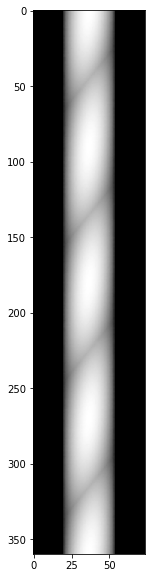

In [5]:
from matplotlib.pylab import imshow, figure

drawable = sinogram[:, 1:]

figure(figsize = (10, 10))
imshow(drawable, cmap = "gray")


In [6]:
def normalize(image):
    import numpy as np

    return (image - image.min()) / (image.max() - image.min())

In [7]:
import numpy as np
from skimage import draw


def inverse_radon(sinogram, phi = 180, size = 0):

    # output image as np.array
    image = np.zeros((size, size))

    # transform to radians
    phi = np.deg2rad(phi)

    # radius //można potem ramke dołożyć
    r = size / 2

    # number of iterations
    iterations = sinogram.shape[0]
    detectors = sinogram.shape[1] - 1
    step = int(360 / iterations)

    print(f"Iteration count: {iterations}")

    in_bounds = lambda point: point[0] >= 0 and point[0] < size and point[1] >= 0 and point[1] < size

    angular_step = phi / (detectors - 1)

    for iteration, alpha in enumerate(range(0, 360, step)):
        alpha = np.deg2rad(alpha)

        # Emitter position
        x_e = r * np.cos(alpha) + r
        y_e = r * np.sin(alpha) + r

        center_angle = alpha + np.pi - phi / 2

        for i in range(detectors):

            # Detector position
            x_d = r * np.cos(center_angle + i * angular_step) + r
            y_d = r * np.sin(center_angle + i * angular_step) + r

            line = draw.line_nd([x_e, y_e], [x_d, y_d])
            line = list(filter(in_bounds, zip(*line)))
            line = list(zip(*line))
            image[line[1], line[0]] += sinogram[iteration, i]

    image = cv.GaussianBlur(image, (3, 3), 0, 0)

    return normalize(image)

In [8]:
from matplotlib.pylab import imshow

img = inverse_radon(sinogram, phi = 180, size = 400)
imshow(img, cmap = "gray")


Iteration count: 360


In [ ]:
from numpy import sqrt, mean


def rmse(image1, image2):
    return sqrt(mean((image1 - image2) ** 2))


In [ ]:
img1 = cv.imread('data/Kolo.jpg', cv.IMREAD_GRAYSCALE)
img2 = img
print(rmse(img1, img2))